In [1]:
from IPython.display import Image,clear_output
%pip install torch torchvision matplotlib albumentations opencv-python segmentation-models-pytorch
%pip install roboflow pandas scikit-learn
%pip uninstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
clear_output()

In [2]:
from roboflow import Roboflow
import os

rf = Roboflow(api_key="4QwtaiJqX1nqiPdAyXcV")
dataset = rf.workspace("dron-hkv6n").project("clasificacion-de-suelo-2").version(15).download("png-mask-semantic", location="content/my-datasets")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import pandas as pd
import torch
from segmentation_models_pytorch.losses import FocalLoss
from sklearn.metrics import confusion_matrix, classification_report

A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
dataset_path = "content/my-datasets"

# Rutas de las carpetas
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
valid_path = os.path.join(dataset_path, "valid")

# Obtener listas de archivos
def get_image_mask_paths(folder):
    # Filtrar solo imágenes originales (sin _mask)
    image_files = sorted([f for f in os.listdir(folder) if f.endswith((".jpg", ".png")) and "_mask" not in f])

    # Generar nombres de las máscaras correctamente
    mask_files = [img.rsplit(".", 1)[0] + "_mask.png" for img in image_files]

    return image_files, mask_files

train_images, train_masks = get_image_mask_paths(train_path)
test_images, test_masks = get_image_mask_paths(test_path)
valid_images, valid_masks = get_image_mask_paths(valid_path)

print(f"Entrenamiento: {len(train_images)} imágenes")
print(f"Validación: {len(valid_images)} imágenes")
print(f"Prueba: {len(test_images)} imágenes")

Entrenamiento: 306 imágenes
Validación: 21 imágenes
Prueba: 14 imágenes


In [5]:
# Leer el archivo CSV
classes_csv = "content/my-datasets/train/_classes.csv"
classes_df = pd.read_csv(classes_csv)

# Obtener el número de clases
num_classes = len(classes_df)
print(f"Número de clases en segmentación: {num_classes}")
print(classes_df)

Número de clases en segmentación: 5
   Pixel Value              Class
0            0         background
1            1               agua
2            2     suelo expuesto
3            3    vegetacion seca
4            4   vegetacion verde


In [6]:
class SoilDataset(Dataset):
    def __init__(self, folder, image_files, mask_files, transform=None):
        self.folder = folder
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        mask_path = os.path.join(self.folder, self.mask_files[idx])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Imagen no encontrada: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Máscara no encontrada: {mask_path}")

        # Cargar imagen y máscara
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Mantener valores originales

        if mask is None:
            raise ValueError(f"Error al cargar la máscara: {mask_path}")

        # Convertir máscara a `int64` antes de las transformaciones
        mask = mask.astype(np.int64)

        # Aplicar transformaciones de Albumentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)  # Ahora no convertimos a numpy
            image, mask = augmented["image"], augmented["mask"]

        # Asegurar que la máscara es `torch.LongTensor`
        mask = mask.long()

        return image, mask

In [7]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [8]:
train_dataset = SoilDataset("content/my-datasets/train", train_images, train_masks, transform)
valid_dataset = SoilDataset("content/my-datasets/valid", valid_images, valid_masks, transform)
test_dataset = SoilDataset("content/my-datasets/test", test_images, test_masks, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=True)

Shape de la imagen: torch.Size([3, 256, 256])
Shape de la máscara: torch.Size([256, 256])


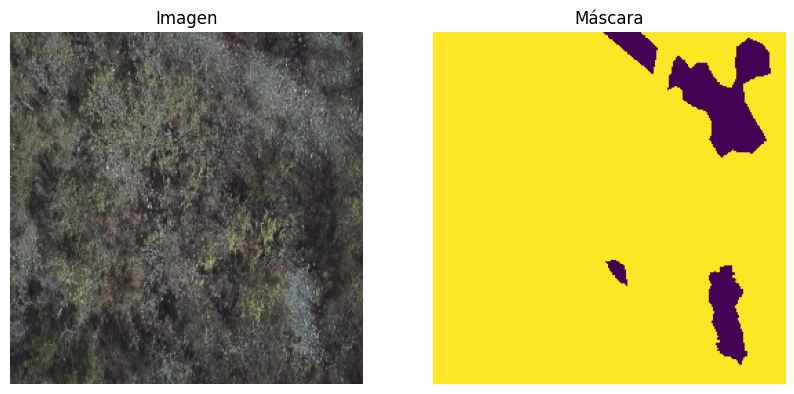

In [9]:
# Obtener imagen y máscara del dataset
image, mask = train_dataset[0]

print(f"Shape de la imagen: {image.shape}")
print(f"Shape de la máscara: {mask.shape}")

# Definir los valores de normalización (deben coincidir con los usados en transforms.Normalize)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# Desnormalizar la imagen
image = image * std + mean  # Invertir normalización
image = torch.clamp(image, 0, 1)  # Asegurar valores en rango [0,1] para matplotlib

# Mostrar imagen y máscara
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).numpy())  # Convertir de (C, H, W) ? (H, W, C)
plt.title("Imagen")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Máscara")
plt.axis("off")

plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes  # Usamos el número de clases desde `_classes.csv`
)

model.to(device)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [11]:
print(device)

cuda


In [12]:
loss_fn = FocalLoss(mode="multiclass", alpha=0.5, gamma=2.0)  # Para segmentación multiclase
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch

num_epochs = 60
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        if images.size(0) == 1:
            continue

        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            if images.size(0) == 1:
                continue

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valid_loader)

    print(f"Época {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model, '../best_models/DEEPLAB.pth')
        print("Nuevo mejor modelo COMPLETO guardado.")
    else:
        epochs_no_improve += 1
        print(f"Sin mejora ({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print("Entrenamiento detenido por early stopping.")
            break

Época 1/100 | Train Loss: 0.2065 | Val Loss: 0.1322
Nuevo mejor modelo COMPLETO guardado.
Época 2/100 | Train Loss: 0.1605 | Val Loss: 0.1847
Sin mejora (1/10)
Época 3/100 | Train Loss: 0.1494 | Val Loss: 0.1842
Sin mejora (2/10)
Época 4/100 | Train Loss: 0.1419 | Val Loss: 0.1842
Sin mejora (3/10)
Época 5/100 | Train Loss: 0.1336 | Val Loss: 0.1732
Sin mejora (4/10)
Época 6/100 | Train Loss: 0.1375 | Val Loss: 0.2359
Sin mejora (5/10)
Época 7/100 | Train Loss: 0.1437 | Val Loss: 0.1618
Sin mejora (6/10)
Época 8/100 | Train Loss: 0.1309 | Val Loss: 0.1656
Sin mejora (7/10)
Época 9/100 | Train Loss: 0.1295 | Val Loss: 0.2017
Sin mejora (8/10)
Época 10/100 | Train Loss: 0.1259 | Val Loss: 0.1495
Sin mejora (9/10)
Época 11/100 | Train Loss: 0.1333 | Val Loss: 0.4272
Sin mejora (10/10)
Entrenamiento detenido por early stopping.


In [14]:
import requests

# Reemplaza con tu token y chat ID
TOKEN = "7582937970:AAEjX_QwxmfjTaFEtJB8ooS4DJ9r782xts8"
CHAT_ID = "7127859860"
MENSAJE = "TERMINO DE ENTRENAR"

# URL de la API de Telegram
URL = f"https://api.telegram.org/bot{TOKEN}/sendMessage"

# Parámetros del mensaje
data = {
    "chat_id": CHAT_ID,
    "text": MENSAJE
}

# Enviar el mensaje
respuesta = requests.post(URL, json=data)

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


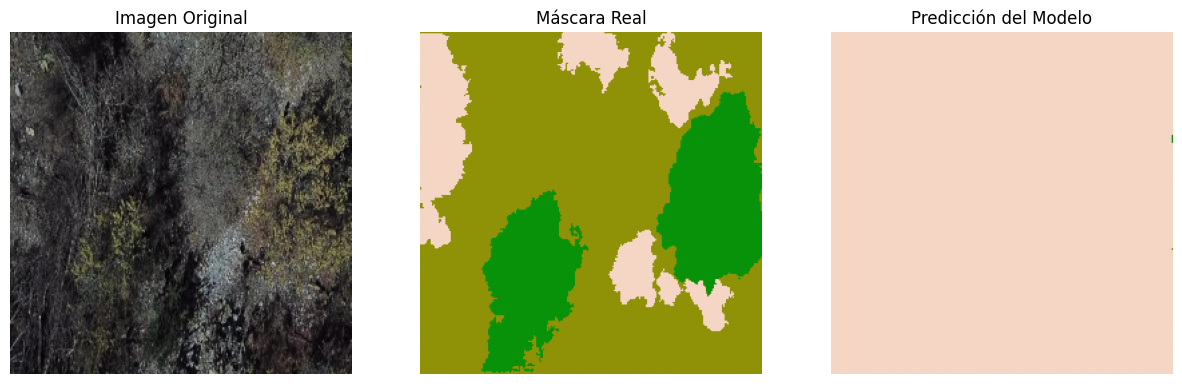

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


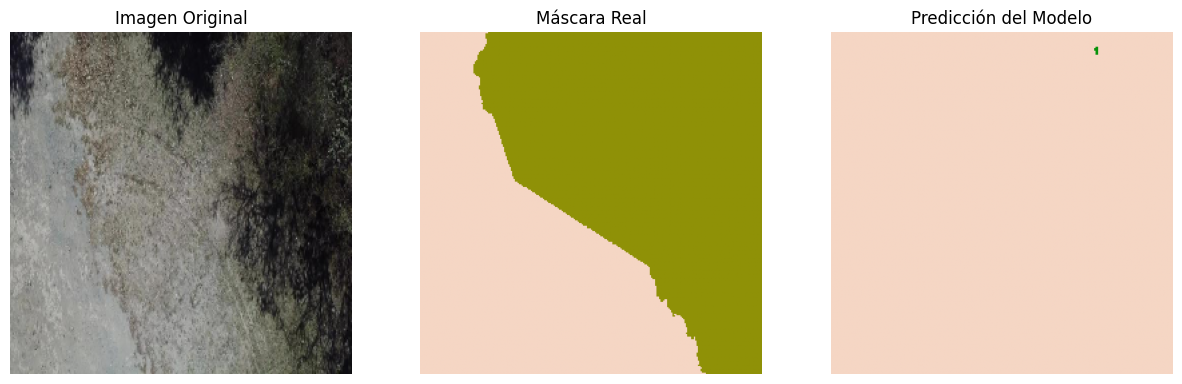

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


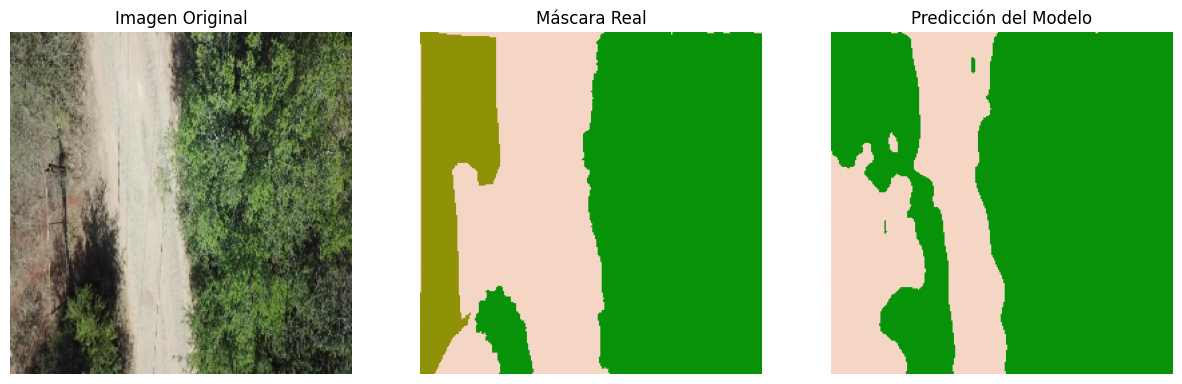

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


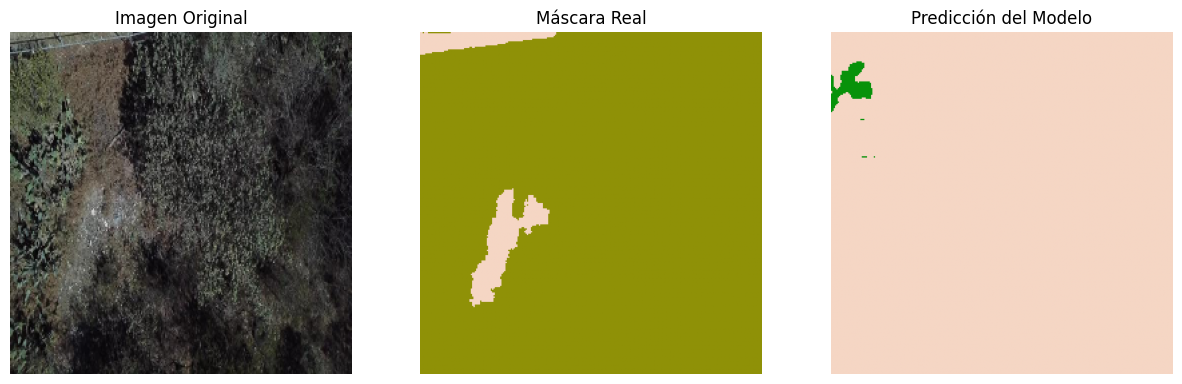

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


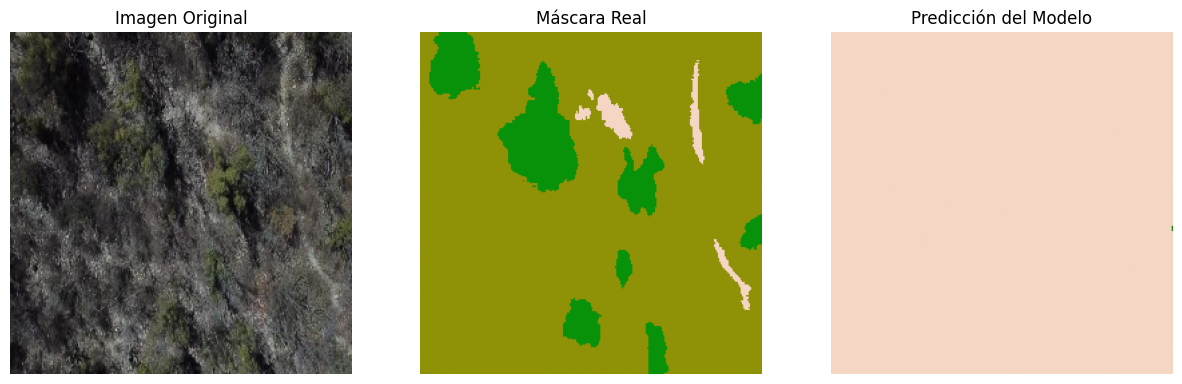

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


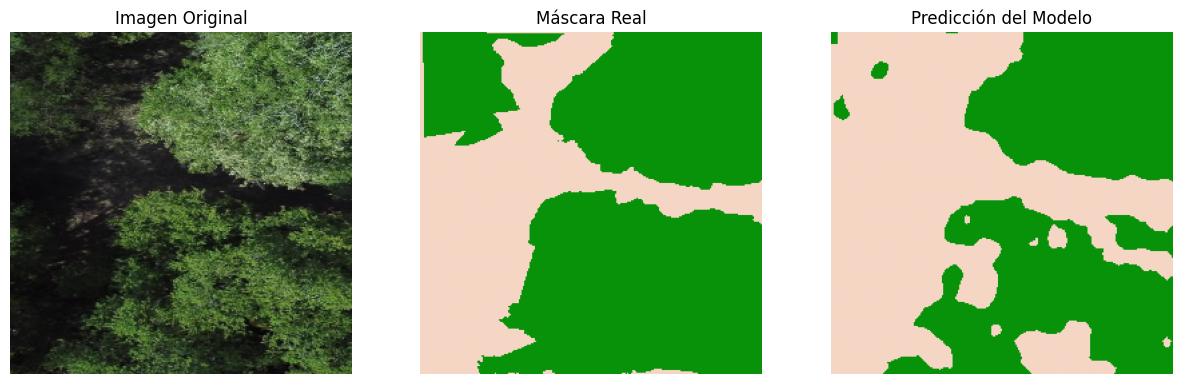

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


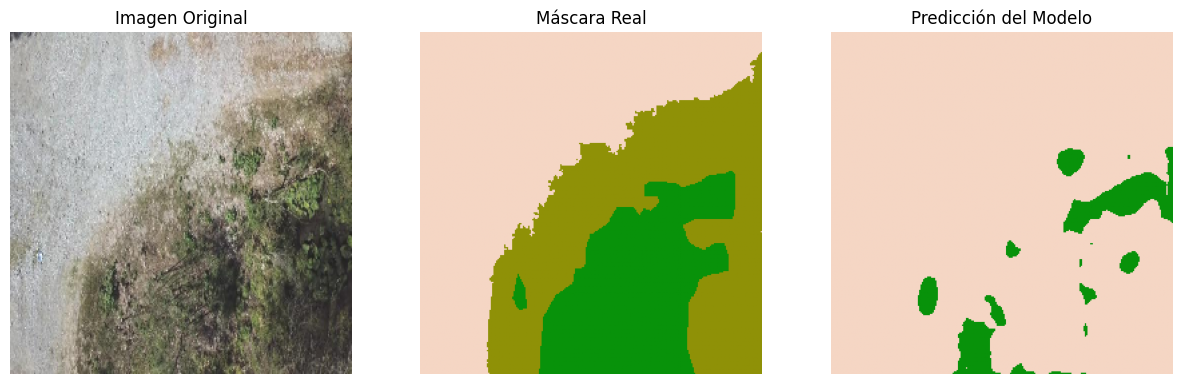

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


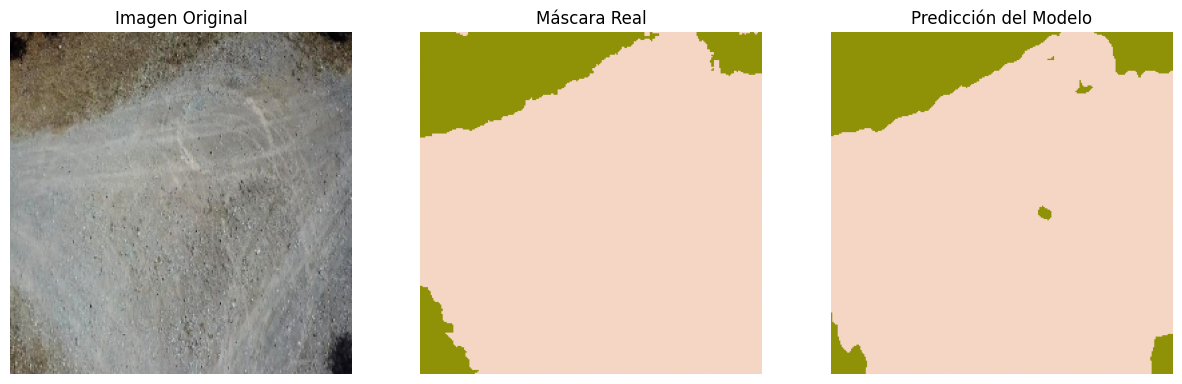

In [15]:
from matplotlib.colors import ListedColormap

# Definir colores personalizados para cada clase
custom_colors = [
    "#000000",  # 0 - Background (Negro)
    "#004fff",  # 1 - Agua (Azul)
    "#f5d6c4",  # 2 - Suelo Expuesto (Blanco)
    "#8f9107",  # 3 - Vegetación Seca (Amarillo)
    "#08920a",  # 4 - Vegetación Verde (Verde)
]

# Crear un colormap personalizado
custom_cmap = ListedColormap(custom_colors)

# Definir el número máximo de imágenes a mostrar
num_images_to_show = 10  
total_count = 0  

# Definir los valores de normalización (deben coincidir con los usados en transforms.Normalize)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Seleccionar la clase más probable

        batch_size = images.shape[0]
        
        for i in range(batch_size):
            if total_count >= num_images_to_show:
                break  

            # **Revisar la forma de la imagen antes de desnormalizar**
            print(f"Shape de la imagen antes de desnormalizar: {images[i].shape}")

            # **Obtener la imagen**
            image_np = images[i].cpu()

            # **Desnormalizar correctamente**
            image_np = (image_np * std + mean)  # Evita que la forma cambie
            image_np = torch.clamp(image_np, 0, 1)  # Asegurar valores en [0,1]

            # **Imprimir forma después de desnormalizar**
            print("Forma después de desnormalización:", image_np.shape)

            # **Aplicar permute()**
            image_np = image_np.permute(1, 2, 0).numpy()  # (C, H, W) ? (H, W, C)

            # Convertir máscara y predicción a NumPy
            mask_np = masks[i].cpu().numpy()
            pred_np = preds[i].cpu().numpy()

            # Mostrar las imágenes
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(image_np)  # Imagen corregida
            plt.title("Imagen Original")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(mask_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
            plt.title("Máscara Real")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
            plt.title("Predicción del Modelo")
            plt.axis("off")

            plt.show()
            total_count += 1  

        if total_count >= num_images_to_show:
            break  

In [16]:
def compute_dice(preds, masks, num_classes=5):
    preds = torch.argmax(preds, dim=1)  # Convertir logits a clases
    dice_per_class = []

    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().float()
        dice = (2. * intersection + 1e-6) / ((preds == cls).sum().float() + (masks == cls).sum().float() + 1e-6)
        dice_per_class.append(dice.item())

    return sum(dice_per_class) / num_classes  # Promedio del F1 Score (Dice)

In [17]:
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Calcular F1 Score (Dice)
        dice_scores.append(compute_dice(outputs, masks, num_classes=5))

# Promediar los valores obtenidos
final_dice_score = sum(dice_scores) / len(dice_scores)
print(f"\nF1 Score (Dice Score): {final_dice_score:.4f}")


F1 Score (Dice Score): 0.6660


In [18]:
def generate_confusion_report(model, test_loader, num_classes=5, class_labels=None, device="cuda"):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convertir logits a clases

            all_preds.extend(preds.cpu().numpy().flatten())
            all_masks.extend(masks.cpu().numpy().flatten())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Generar reporte de clasificación
    report = classification_report(all_masks, all_preds, target_names=class_labels, digits=4)

    return cm, report

In [19]:
class_labels = ["Suelo Expuesto", "Vegetación Seca", "Vegetación Verde"]

In [20]:
# Generar reporte de matriz de confusión y clasificación
cm, report = generate_confusion_report(model, test_loader, num_classes=4, class_labels=class_labels, device=device)

In [21]:
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
                  precision    recall  f1-score   support

  Suelo Expuesto     0.4005    0.9584    0.5649    172149
 Vegetación Seca     0.5826    0.0798    0.1403    238174
Vegetación Verde     0.8154    0.5702    0.6711    113965

        accuracy                         0.4749    524288
       macro avg     0.5995    0.5361    0.4588    524288
    weighted avg     0.5734    0.4749    0.3951    524288



In [22]:
# Guardar todo el modelo
# torch.save(model, "../models/clasificacion4.pth")